In [1]:
library(tidyverse)
library(patchwork)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
figsize = \(width=8,height=4) options(repr.plot.width=width, repr.plot.height=height)
figsize()

noise = \(x) x + rnorm(n = length(x))
expit = \(x) rbinom(prob = 1/(1+exp(-x)), size = 1, n = length(x))

# Effect and Bias
[$d$-Separation](https://www.dagitty.net/learn/dsep/index.html) is the tool to give us a set of variables need to be conditioned to get exchangeability between two interesting variables on causal graph. It's an intuitive and concise procedure, however, users need to check a whole state of graph everytime they changes the conditioned variables. $d$-Separation is a set of sufficient conditions that achieves an exchangeability of two variables. What if we can utilize a set of necessary conditions and can check if the exchangeability holds to construct a set of conditioned variables one-by-one? Let's re-think about what we need to care about for valid causal effect inference.

When causal graph is given, "effect" means a predicted or acceptable correlation between two variables(black arrow).

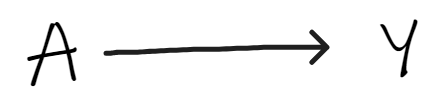

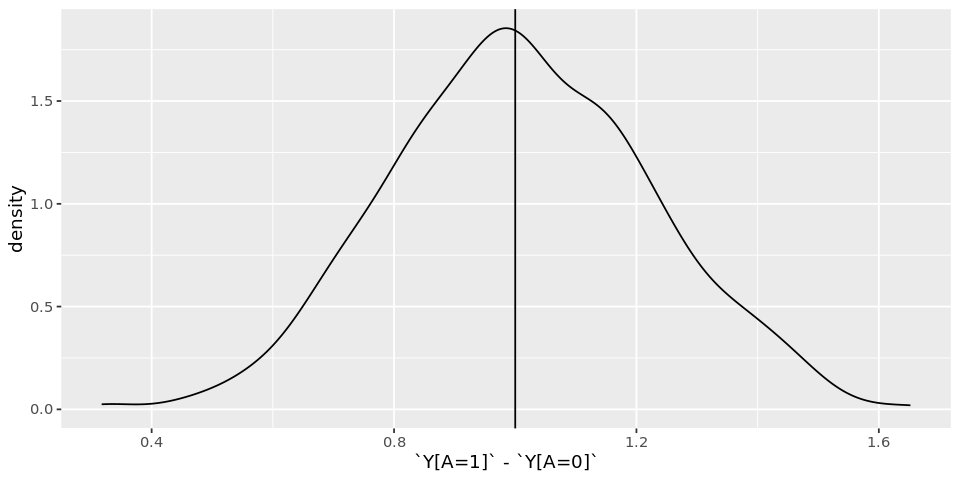

In [3]:
data = data.frame(N=1:1000) %>%
    rowwise() %>%
    reframe({
        A = expit(rep(0,100))
        Y = noise(A)
        data.frame(N,A,Y)
    })

data %>%
    group_by(N,A) %>%
    reframe(Y = mean(Y)) %>%
    pivot_wider(names_from = A, values_from = Y, names_glue = 'Y[A={A}]') %>%
    ggplot() +
    geom_density(aes(x=`Y[A=1]`-`Y[A=0]`)) +
    geom_vline(xintercept = 1)

Stratified analysis gives good estimations of the effect of A on Y, that is the value of coefficient of A in formula of Y = A. But we can do the same analysis by swapping A and Y by some binning for Y.

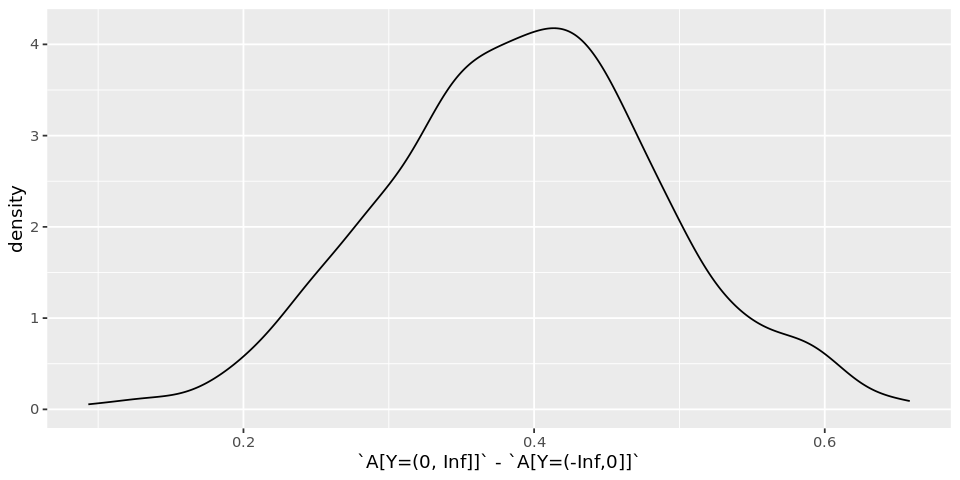

In [4]:
data %>%
    group_by(N,Y=cut(Y,breaks=c(-Inf,0,Inf))) %>%
    reframe(A = mean(A)) %>%
    pivot_wider(names_from = Y, values_from = A, names_glue = 'A[Y={Y}]') %>%
    ggplot() +
    geom_density(aes(x=`A[Y=(0, Inf]]` - `A[Y=(-Inf,0]]`))

There is some difference on two mean of A with conditioned Y, but we're not interested in and want to remove as possible from total estimation of causal effect. Let's call this "bias" and draw as red line.

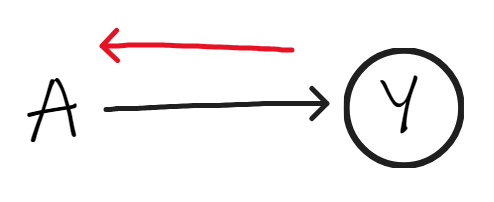

Circle on variable Y means that's conditioned. When we estimate an effect of A on Y in previous graph, we actually had conditioned on A.
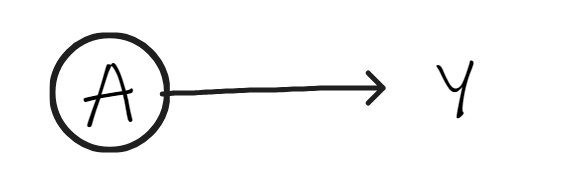

Note that all biases(red arrow) emerge from conditioned variables. This reflect all biases are caused by conditioning even that's on only the single most interesting variable.

## Chain of bias
Given next causal graph and try to condition on C. What will happen?
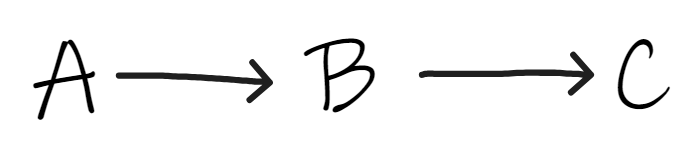

In [5]:
data = data.frame(N=1:1000) %>%
    rowwise() %>%
    reframe({
        A = expit(rep(0,100))
        B = expit(A-0.5)
        C = expit(B-0.5)
        data.frame(N,A,B,C)
    })

Condition free distribution of E[A] is as follows.

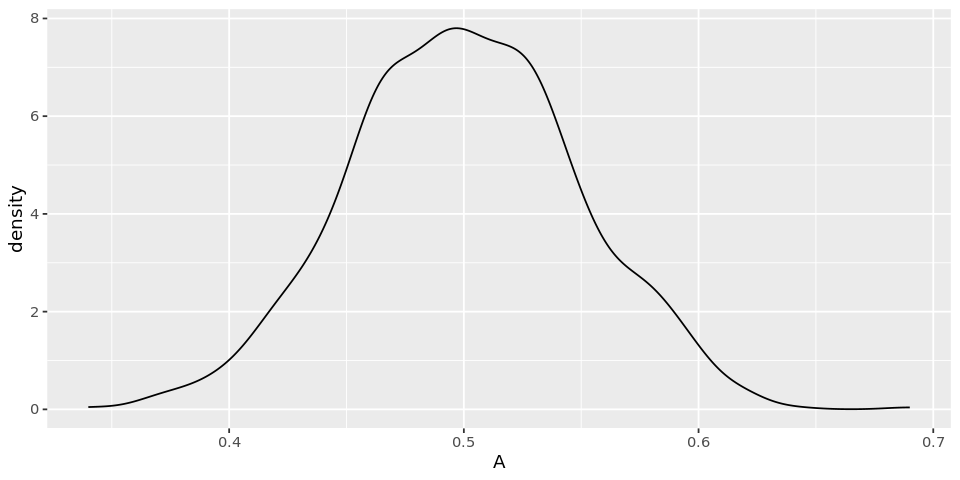

In [6]:
data %>%
    group_by(N) %>%
    reframe(A = mean(A)) %>%
    ggplot() +
    geom_density(aes(A))

Same for conditioned C, E[A|C].

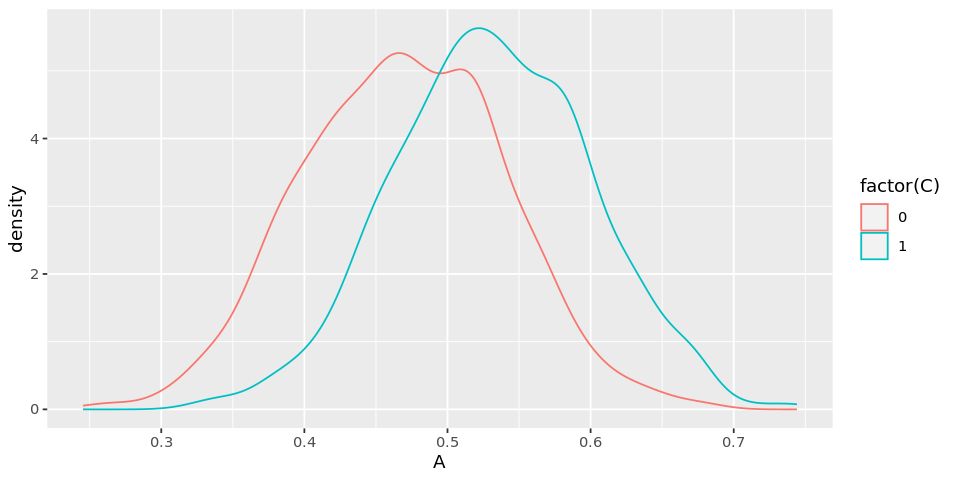

In [7]:
data %>%
    group_by(N,C) %>%
    reframe(A = mean(A)) %>%
    ggplot() +
    geom_density(aes(A,color=factor(C)))

This gives us insight that the bias reversely traverses to parent, call this the chain of bias.
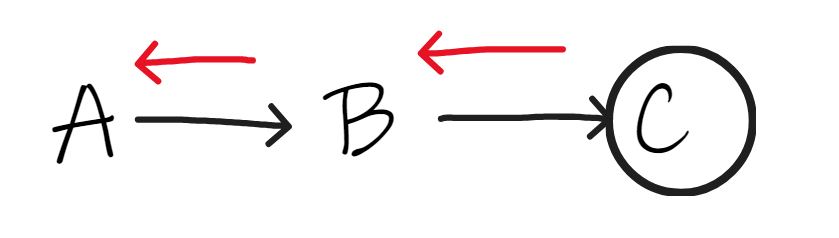

## Biased path
Next causal graph never make the chain of bias when conditioned on C.
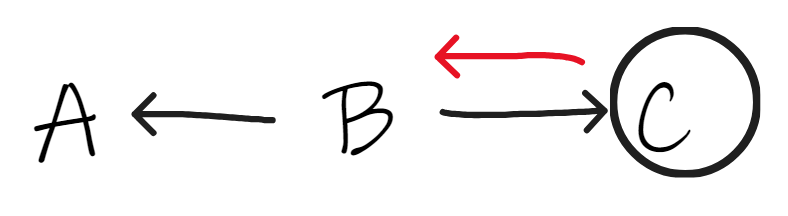
Does it mean E[A|C] is free from bias?

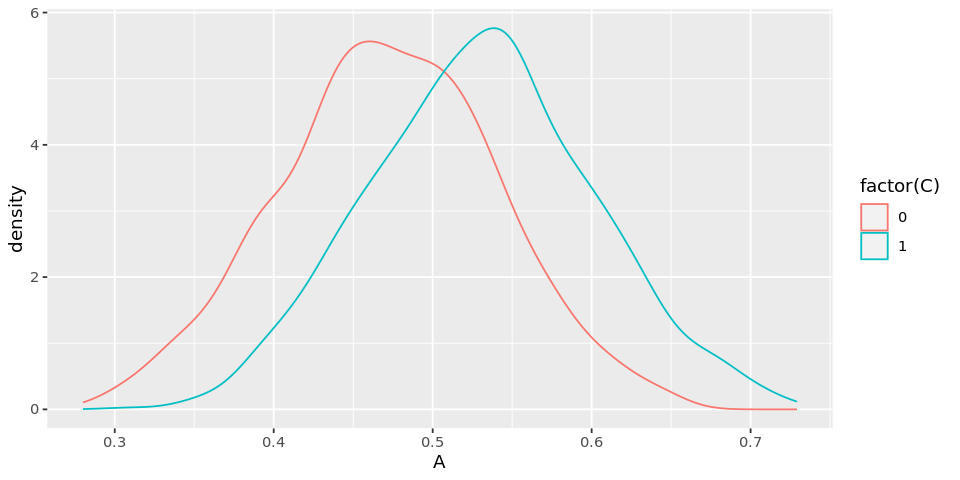

In [8]:
data = data.frame(N=1:1000) %>%
    rowwise() %>%
    reframe({
        B = expit(rep(0,100))
        A = expit(B-0.5)
        C = expit(B-0.5)
        data.frame(N,A,B,C)
    })
data %>%
    group_by(N,C) %>%
    reframe(A=mean(A)) %>%
    ggplot() + 
    geom_density(aes(A,color=factor(C)))

This is caused by the "biased path" that contains bias in the path running into A from C. What if conditioned on B?
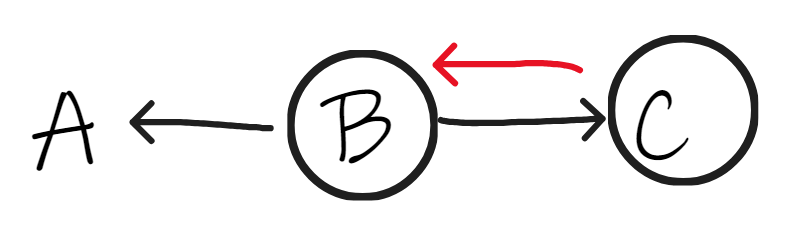

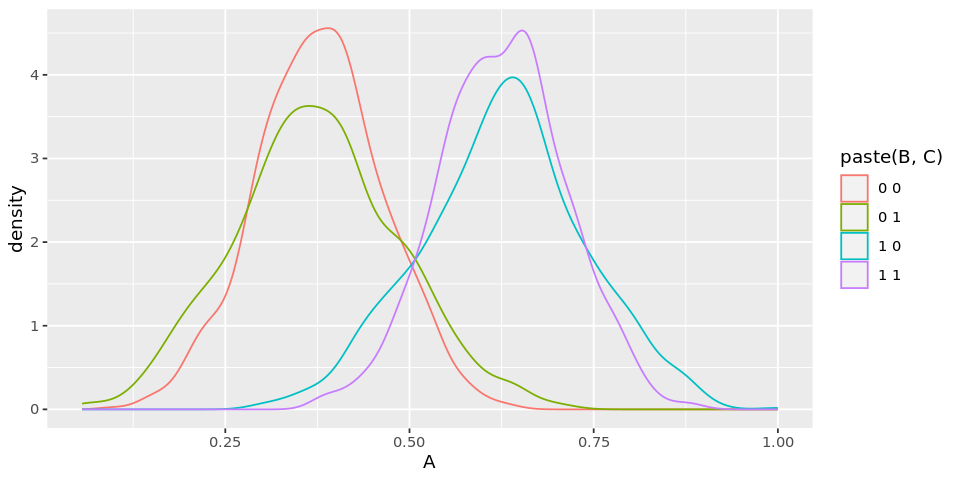

In [9]:
data %>%
    group_by(N,C,B) %>%
    reframe(A=mean(A)) %>%
    ggplot() + 
    geom_density(aes(A,color=paste(B,C)))

We can see that the means of A has the same value when B is the same whatever C is. This can be written in math as
$$
E[A|B,C] = E[A|B].
$$
This means we can isolate the bias from C to A by conditioning on B in causal graph.

More formally, biased path to variable A is every forward traversing paths 
1. that run into A from conditioned variable X,
2. that never contains other conditioned variable except X,
3. and contains at least one bias.

Now we can construct a set of variables need to be conditioned for exchangeability one-by-one. Let's see that in next chapter.

# Typical structures in causal inference
In causal inference, there are three famous structures: confounder, mediator, and collider. Let's analyse these by the concept of biased path.

## Confounder
Confounder L is like this.
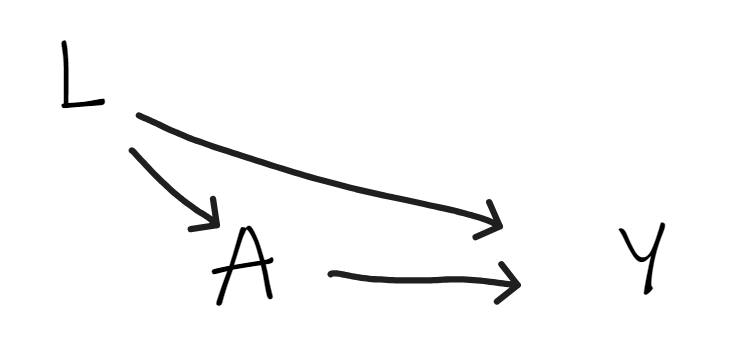

We always interested in the effect A on Y. So condition on A.
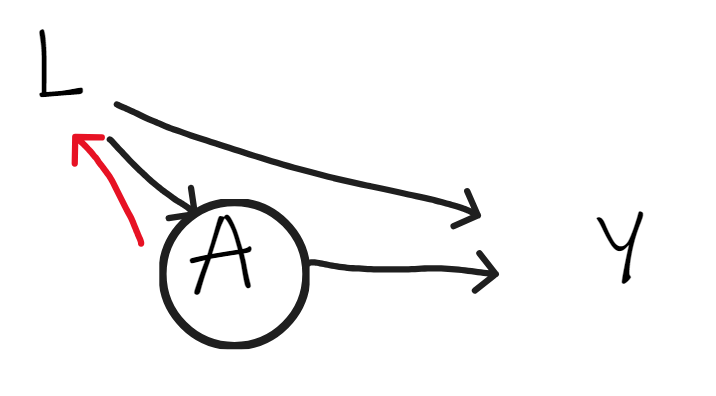

Biased path A->L->Y is open now, so condition on L to block the bias.
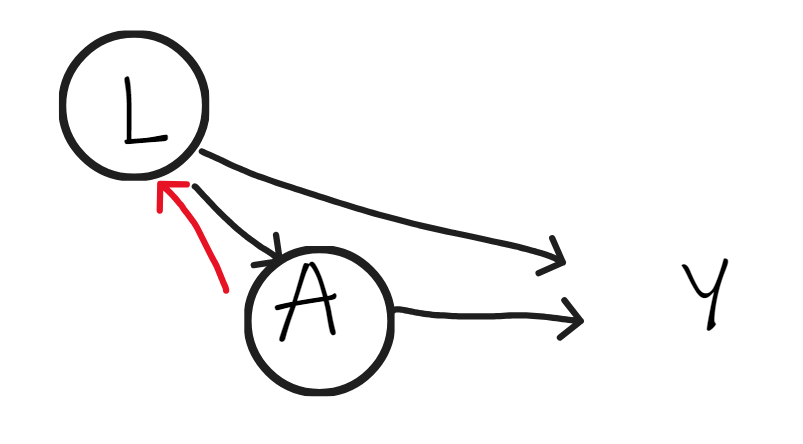

Even the bias from A is isolated by L, there is an effect of A on Y. So, in general, $E[Y|L,A] \ne E[Y|L]$.

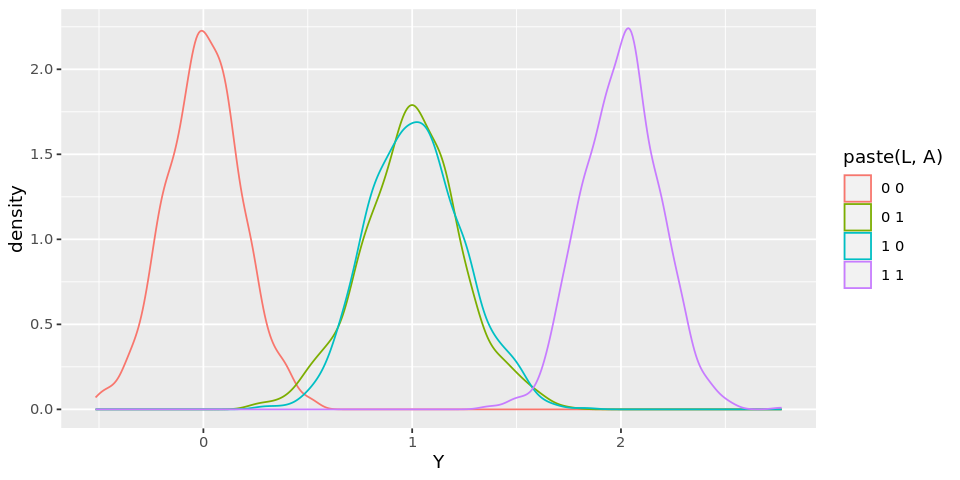

In [10]:
data = data.frame(N=1:1000) %>%
    rowwise() %>%
    reframe({
        L = expit(rep(0,100))
        A = expit(L-.5)
        Y = noise(L+A)
        data.frame(N,A,Y,L)
    })

data %>%
    group_by(N,A,L) %>%
    reframe(Y = mean(Y)) %>%
    ggplot() +
    geom_density(aes(Y, color=paste(L,A)))

Note that, however, we can see that two differences $$E[Y[a=1] - Y[a=0] \mid L=l], \forall l \in \{0,1\}$$ have the similar value of 1 that's coefficient of A on Y. This parity of two differences under L is the property the exchangeability guarantees.

What if remove the conditioning on L?

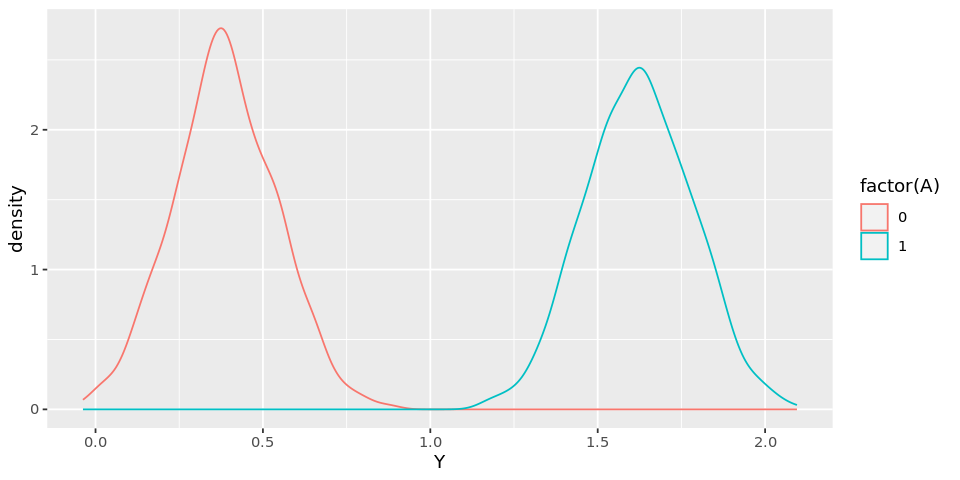

In [11]:
data %>%
    group_by(N,A) %>%
    reframe(Y = mean(Y)) %>%
    ggplot() +
    geom_density(aes(Y, color=factor(A)))

The difference $E[Y[a=1] - Y[a=0]]$ is not 1 in this case. This is caused by the bias of conditioned A on Y in previous causal graph.

## Mediator

Mediator M is like this.
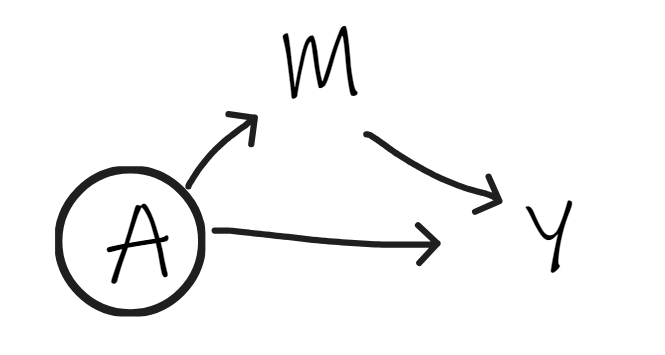

There is no bias(red arrow). What is the difference?

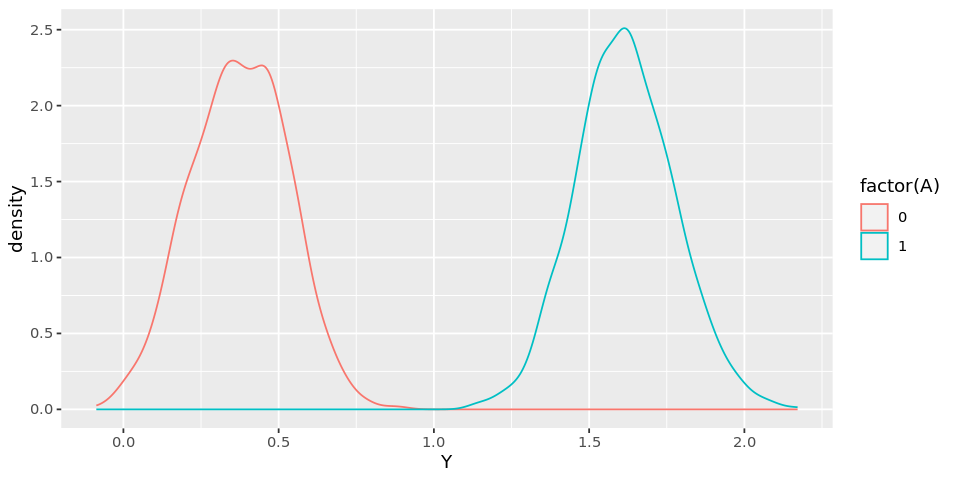

In [12]:
data = data.frame(N=1:1000) %>%
    rowwise() %>%
    reframe({
        A = expit(rep(0,100))
        M = expit(A-0.5)
        Y = noise(M+A)
        data.frame(N,A,Y,M)
    })

data %>%
    group_by(N,A) %>%
    reframe(Y = mean(Y)) %>%
    ggplot() +
    geom_density(aes(Y, color=factor(A)))

$E[Y[a=1]-Y[a=0]]$ is not 1 here. This is called "total effect of A on Y" that contains the bypassed path from A to Y in the estimation. We can condition on M to see only the direct effect of A on Y.
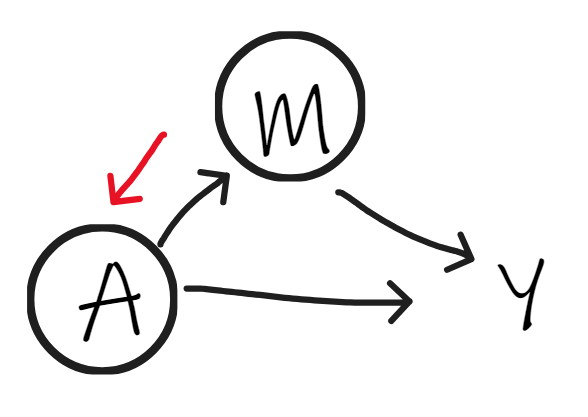

This introduces new bias from M, but it's already isolated by A.

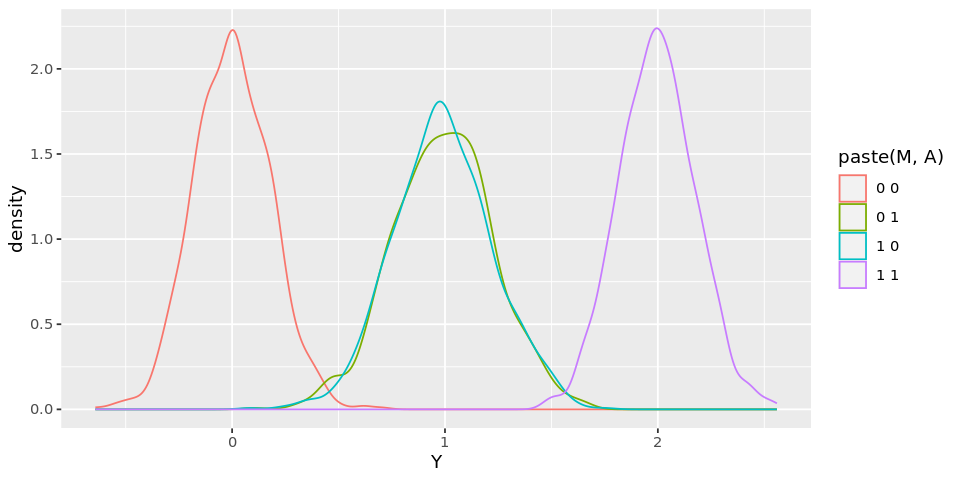

In [13]:
data %>%
    group_by(N,A,M) %>%
    reframe(Y = mean(Y)) %>%
    ggplot() +
    geom_density(aes(Y, color=paste(M,A)))

Two differences on the same M has the value near 1. Interestingly this graph is very similar to the confounder's case. The effect(black arrow) and bias(red arrow) on causal graph cannot be distinguished on numerical calculation stage. But the difference $E[Y[a=1]-Y[a=0]]$ for mediator'case is justifiable by the argument on causal graph while is not for confounder's case. It's the original intention or question of doing causal inference decides what kind of effects are needed.

## Collider

Collider C is like this.
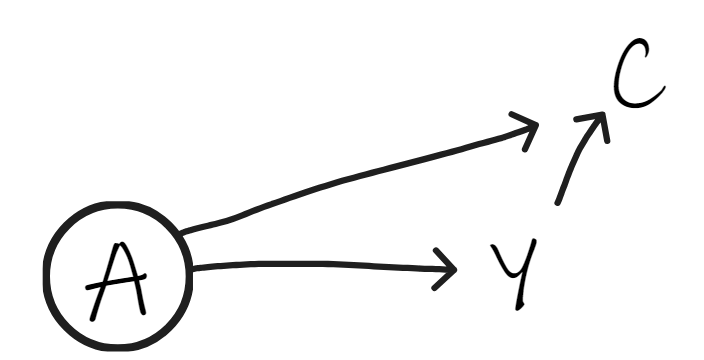

There is no bias so we can estimate the effect of A on Y, especially direct effect in this case.

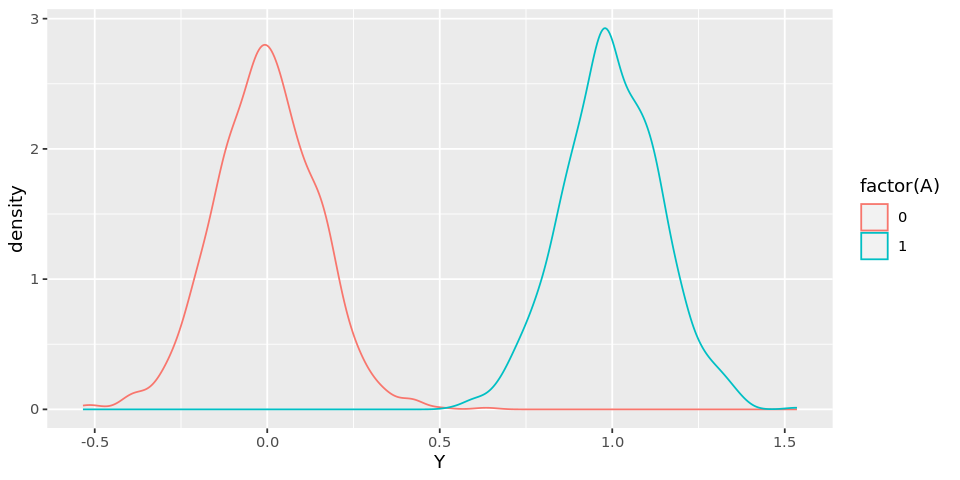

In [14]:
data = data.frame(N=1:1000) %>%
    rowwise() %>%
    reframe({
        A = expit(rep(0,100))        
        Y = noise(A)
        C = expit(A+Y-1)
        data.frame(N,A,Y,C)
    })

data %>%
    group_by(N,A) %>%
    reframe(Y = mean(Y)) %>%
    ggplot() +
    geom_density(aes(Y, color=factor(A)))

What if conditioned on C?
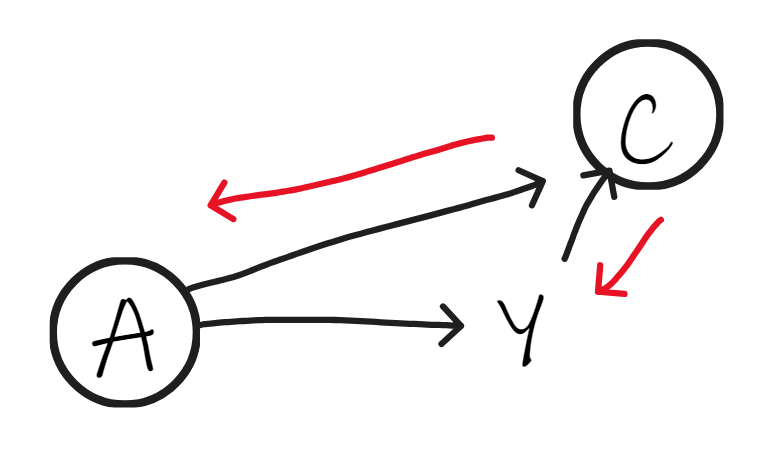
This opens direct biased path from C to Y.

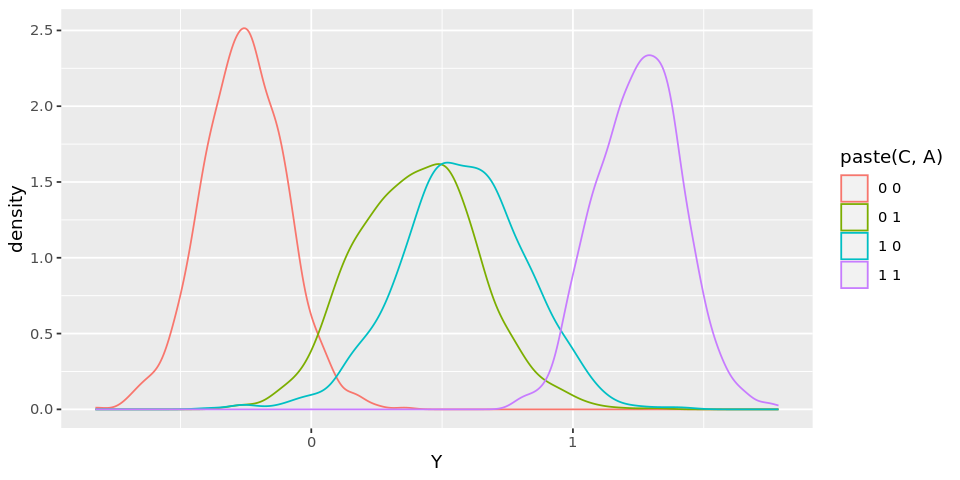

In [15]:
data %>%
    group_by(N,A,C) %>%
    reframe(Y = mean(Y)) %>%
    ggplot() +
    geom_density(aes(Y, color=paste(C,A)))

Let's see differences directly.

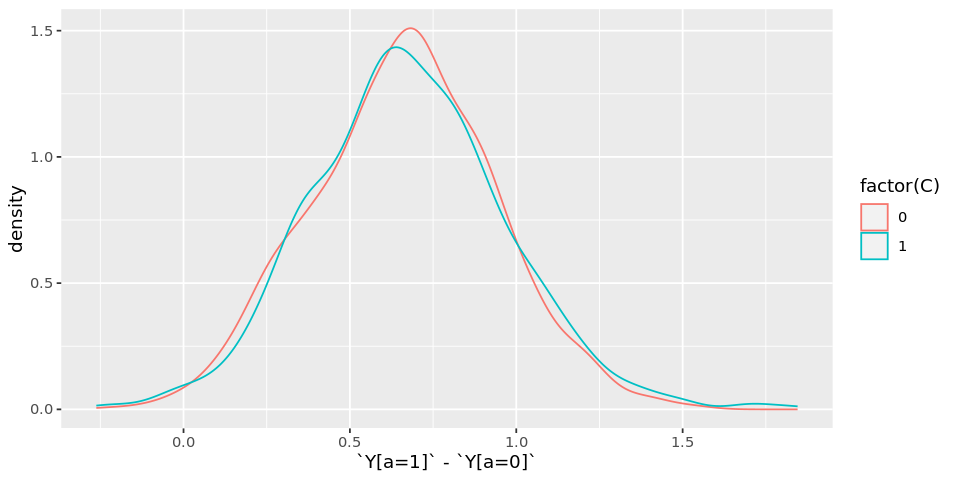

In [16]:
data %>%
    group_by(N,A,C) %>%
    reframe(Y = mean(Y)) %>%
    pivot_wider(names_from = A, values_from = Y, names_glue = 'Y[a={A}]') %>%
    ggplot() +
    geom_density(aes(`Y[a=1]`-`Y[a=0]`, color=factor(C)))

Two differences consistently differ from 1 even both are a very close value. This total bias is introduced by the bias of C on Y.

What if some variables intercept the bias of C on Y?
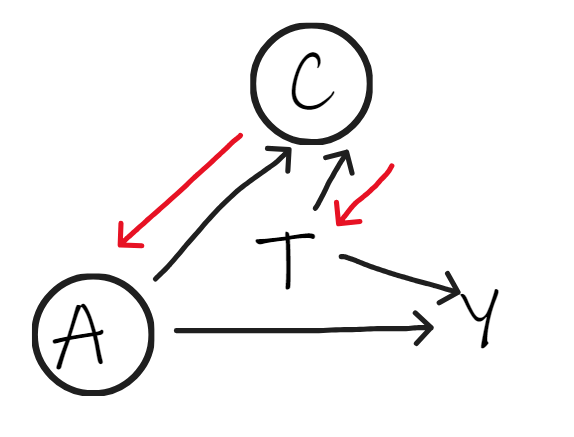

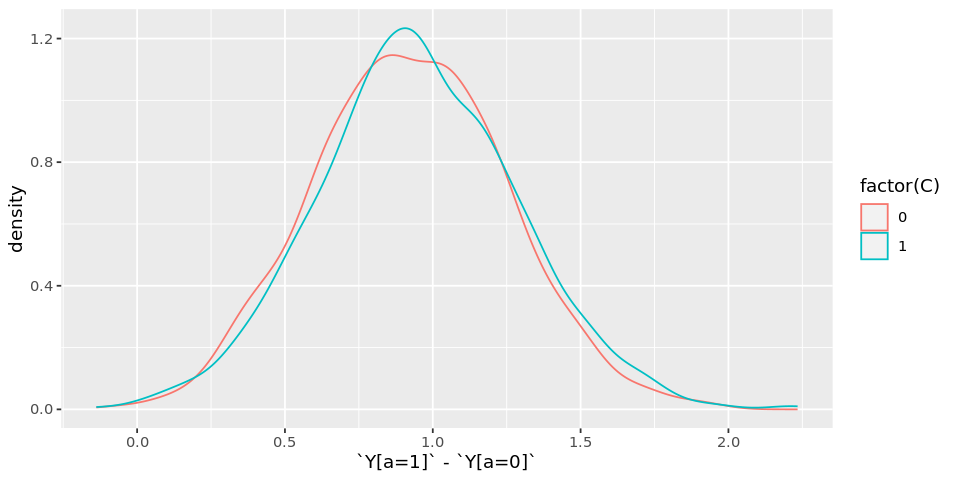

In [17]:
data = data.frame(N=1:1000) %>%
    rowwise() %>%
    reframe({
        A = expit(rep(0,100))        
        T = expit(rep(0,100))
        Y = noise(A+T)
        C = expit(A+T-1)
        data.frame(N,A,Y,C,T)
    })

data %>%
    group_by(N,A,C) %>%
    reframe(Y = mean(Y)) %>%
    pivot_wider(names_from = A, values_from = Y, names_glue = 'Y[a={A}]') %>%
    ggplot() +
    geom_density(aes(`Y[a=1]`-`Y[a=0]`, color=factor(C)))

Differences is near 1 in spite of there is biased path. What if conditioned on T?
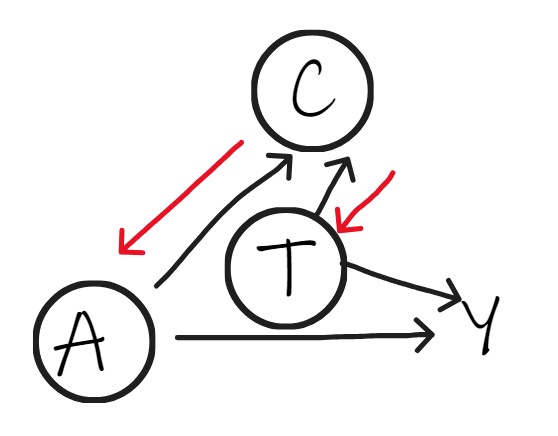

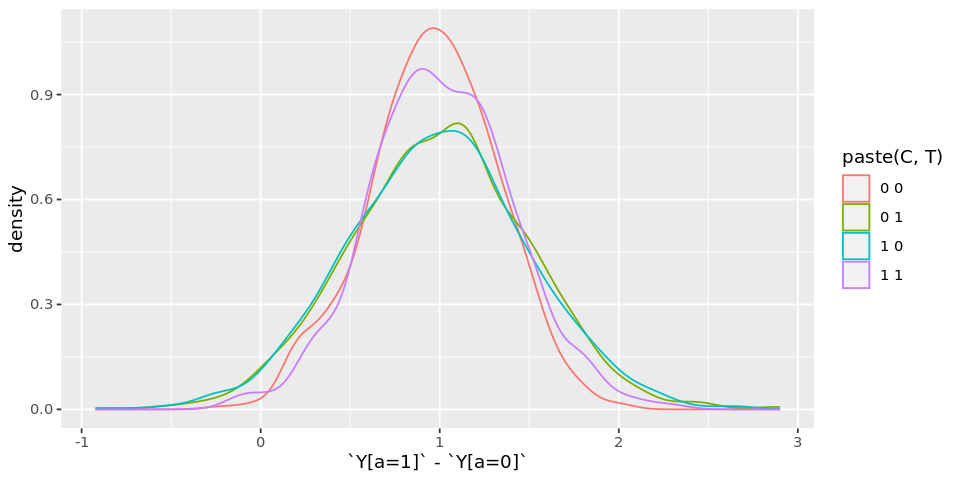

In [18]:
data %>%
    group_by(N,A,C,T) %>%
    reframe(Y = mean(Y)) %>%
    pivot_wider(names_from = A, values_from = Y, names_glue = 'Y[a={A}]') %>%
    ggplot() +
    geom_density(aes(`Y[a=1]`-`Y[a=0]`, color=paste(C,T)))

It's hard to see critical differences between two cases. This is caused by the randomness of the effect of T on Y, that blurs the bias of C on T in this case. Using causal graph, however, is very conservative that prefers safety choices of estimations over cost of considering many variables. It can hardly be expected such fortunes would happen in real-world scenarios.

# More complicated things

In real world, more complicated causal graphs are assumed explicitly or implicitly.
Before delving into those topics, we define some notations for causal inference.

## Notations and Assumptions

Random variables $X$ are capital and its realizations $x$ are small letters.
We use the notation of the expectation of $f(X)$ over a distribution $P(X)$ as
$$
E[X] f(x) = \int dx P(X=x) f(x)
$$
where $E[\cdot]$ is an right-associative operator as
$$
\begin{align}
E[X] E[Y\mid X] f(X,Y) & = E[X] (E[Y\mid X] f(X,Y)) \\
\end{align}
$$

In clinical trial, we need to estimate causal effects of treatment $A\in\{0,1\}$ on outcome $Y$ over known covariates $L$ of target population. Each patients in the trial has one record and cannot take two treatment $a=1$ and $a=0$ at once. We're interested into the potential outcome $Y[i,A=a]$ of patients $i$ when this person takes treatment $A[i]=a$ under some conditions. $i$ is omitted for simplicity unless needed.

$E[Y\mid A=1] Y$ means that extract all records from data with condition $A=1$, then calculate mean of $Y$ the measured outcome. Average of potential outcome $Y[a=1]$ is calculable under $A=1$ but not under $A=0$ because we assume a consistency that the measured outcome $Y$ for whose treatment $A=a$ is always $Y[a]$. This consistency is written as
$$
E[Y[a]\mid A=a] f(Y[a]) = E[Y\mid A=a] f(Y).
$$

The "causal effect" is the difference of two outcome $Y[a=1]$ and $Y[a=0]$ of the same person that's not measureable in practice. Instead we assume we can use the measured outcome of other person the way how treatment affect is very similar. Covariates $L$ is expected to have enough informations for this. This assumption is called exchangeability and written as
$$
Y[a]\perp A \mid L
\Longleftrightarrow
E[Y[a]\mid L, A=1] = E[Y[a]\mid L, A=0] = E[Y[a]\mid L]
$$

And we need another assumption to make the exchangeability works, that is called positivity written as
$$
0 < P(A=a\mid L) < 1.
$$
If all similar persons always take the same treatment, we cannot use their outcome as potential outcome with another treatment.

## Standardization and IPW
Most basic methods to calcualte the causal average treatment effect are standardization and inverse propensity weighting(IPW) method. Both can be derived very easily with our notation. Average potential outcome $E[Y[a]] Y[a]$ is
$$
\begin{align}
E[Y[a]] Y[a]
& = E[L] E[Y[a]\mid L] Y[a] & \text{law of probability} \\
& = E[L] E[Y[a]\mid L, A=a] Y[a] & \text{exchangeability} \\
& = E[L] E[Y\mid L, A=a] Y & \text{consistency} \\
\end{align}
$$
Last formula is called standardization method that uses a model predicts the average of measured outcome $Y$ under condition $L,A=a$ and use the weighted average with $P(L)$ as the average potential outcome.

We can further transform the standardization formula
$$
\begin{align}
E[Y[a]]Y[a] 
& = E[L] E[Y\mid L,A=a] Y \\
& = E[Y,L,A=a] \frac{Y I(A=a)}{P(A=a\mid L)} \\
& = E[Y,L|A=a] \frac{Y P(A=a)}{P(A=a\mid L)}
\end{align}
$$
where $I(A=a)$ is indicator function.
Last two formulas are called IPW and IPW with stable weight respectively.

As we can wee two methods are mathematically identical, however, they are used according to the problem to be solved in practice.

## Relation exchangeability and causal graph
Exchangeability is not the things on calculation stage but is on causal graph.
When we want to calculate causal effects of treatment $A$ on outcome $Y$, we need to close all biased path by conditioning on $A$ that potentially run into $Y$.
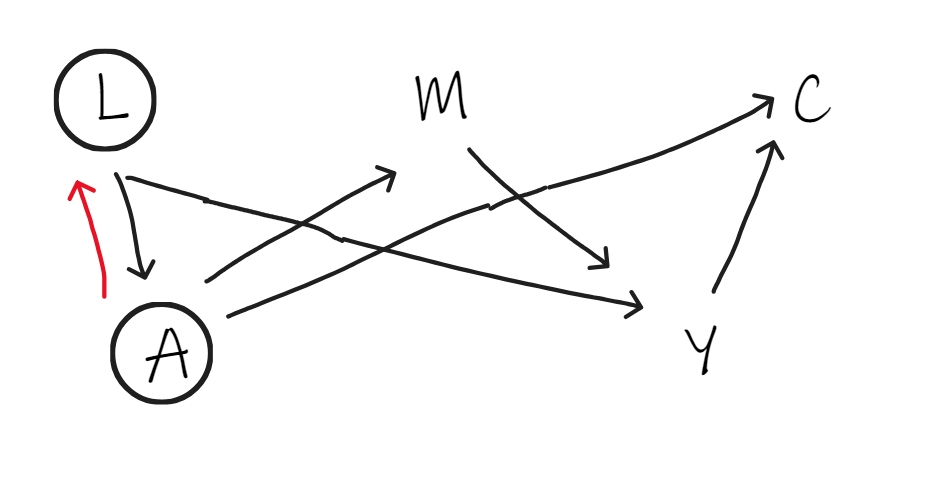

In the above graph, we can't say the exchangeability $P(Y\mid L,A)=P(Y\mid L)$ holds since changes of $A$ affect on $Y$ via $M$. All biased path to $Y$ is already closed so we need to decide how treat $M$. If you want to know total effects of $A$ on $Y$ including the one mediated by $M$, then remove $M$.
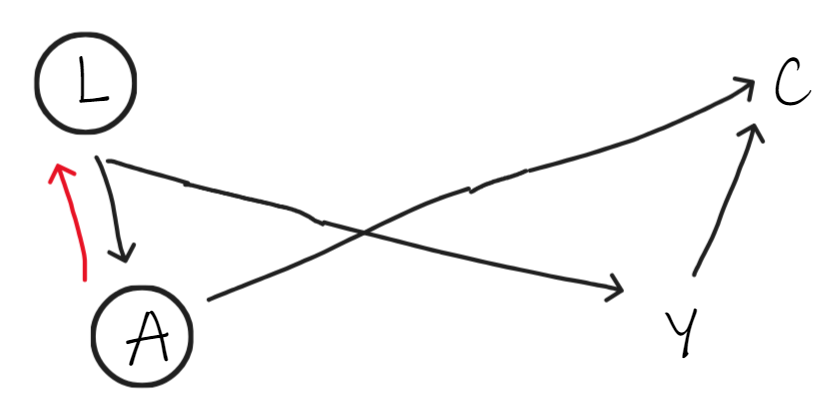

Now $P(Y\mid L,A) = P(Y\mid L)$ holds. If you want only direct effect of $A$ on $Y$, condition on $M$.
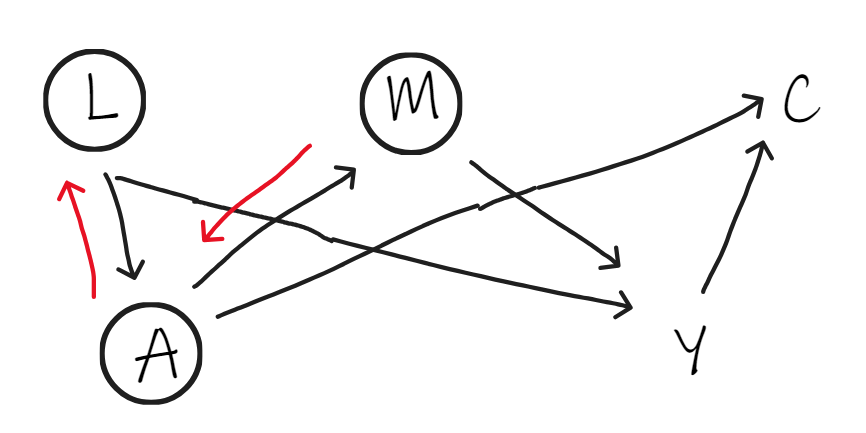

Now different exchangeability $P(Y\mid L,M,A) = P(Y\mid L,M)$ holds. 

If we observed changes of $Y$ while changing $A$, that appears as non-zero causal average effect, in spite of the exchangeability holds that states any changes of $A$ never affect on $Y$, then we say that treatment $A$ has causal effect on outcome $Y$. This is the way of thinking in causal inference.